#Этап 1
Подключение необходимых библиотек

In [1]:
# for loading/processing the images  
from tensorflow import keras
from keras.utils import load_img
from keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

Получение изображений построенных по логу helpdesk.csv при помощи класса ActicityConverter

In [2]:
path = r"/content/drive/MyDrive/CourseProject/Test_1/Images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
images = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
  for file in files:
    if file.name.endswith('.png'):
      # adds only the image files to the images list
      images.append(file.name)
            
            
            


#Этап 2
Подключение предобученной модели CNN VGG16

VGG16 — это сверточная нейронная сеть, которая считается передовой для задач распознавания изображений. Мы собираемся использовать эту модель только в качестве экстрактора признаков, что означает, что мы удалим последний (прогнозирующий) слой, чтобы мы могли получить вектор признаков.

подробнее в гайде, из которго были взяты материалы: https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [3]:
model = VGG16()

553467096/553467096 [==============================] - 3s 0us/step


Процесс извлечения признаков

In [5]:
def extract_features(file, model):
  # load the image as a 224x224 array
  img = load_img(file, target_size=(224,224))
  # convert from 'PIL.Image.Image' to numpy array
  img = np.array(img) 
  # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
  reshaped_img = img.reshape(1,224,224,3) 
  # prepare image for model
  imgx = preprocess_input(reshaped_img)
  # get the feature vector
  features = model.predict(imgx, use_multiprocessing=True)
  return features
   
data = {}

delimetr = 0
# lop through each image in the dataset
for image in images:
  # try to extract the features and update the dictionary
  feat = extract_features(image,model)
  data[image] = feat
  delimetr += 1
  print(delimetr)
  if (delimetr == 100):
    break
    
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))


1/1 [==============================] - 1s 652ms/step
1
1/1 [==============================] - 1s 674ms/step
2
1/1 [==============================] - 1s 614ms/step
3
1/1 [==============================] - 1s 606ms/step
4
1/1 [==============================] - 1s 605ms/step
5
1/1 [==============================] - 1s 596ms/step
6
1/1 [==============================] - 1s 601ms/step
7
1/1 [==============================] - 1s 601ms/step
8
1/1 [==============================] - 1s 1s/step
9
1/1 [==============================] - 1s 1s/step
10
1/1 [==============================] - 1s 1s/step
11
1/1 [==============================] - 1s 1s/step
12
1/1 [==============================] - 1s 813ms/step
13
1/1 [==============================] - 1s 603ms/step
14
1/1 [==============================] - 1s 616ms/step
15
1/1 [==============================] - 1s 593ms/step
16
1/1 [==============================] - 1s 615ms/step
17
1/1 [==============================] - 1s 617ms/step
18
1/1 [========

In [6]:
feat = feat.reshape(-1,1000)
data = pd.DataFrame(feat)

#Этап 3

Применяем метод k-средних (k-means clustering) из библиотеки sklearn.cluster.KMeans для обнаружения вероятного количество различых классов.

Понимаем количество классов по обнаружению излома на грфике, в данном случае он наиболее явно виден в точке 7, то есть определяем как 7 классов.

<ipython-input-7-b6c9f297164b>:12: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  kmeans.fit(data)
<ipython-input-7-b6c9f297164b>:12: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  kmeans.fit(data)
<ipython-input-7-b6c9f297164b>:12: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans.fit(data)


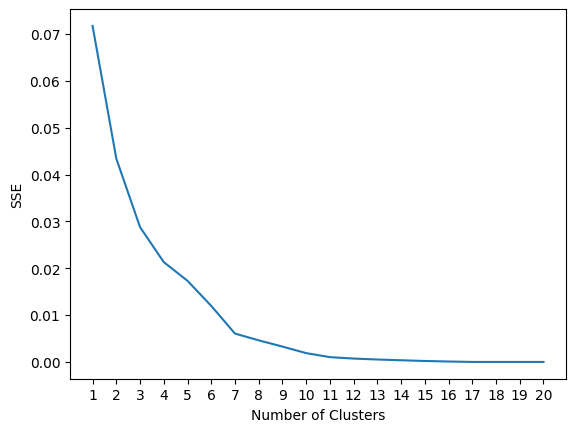

In [7]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 20,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 21):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(data)
  sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#Этап 4
Производим класстеризацию за счёт библиотеки sklearn.cluster.KMeans. Сохраняем изображения, отнесенные к одному класстеру, в массив, и данные группы сохраняем в едином массиве (получаем массив массивов).

In [8]:
unique_labels = 7

In [9]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=unique_labels, random_state=22)
kmeans.fit(x)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=7, random_state=22)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

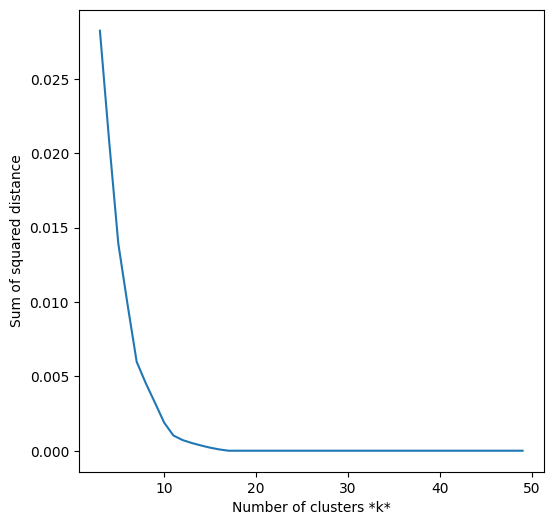

In [10]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
  if cluster not in groups.keys():
    groups[cluster] = []
    groups[cluster].append(file)
  else:
    groups[cluster].append(file)

# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
  plt.figure(figsize = (25,25));
  # gets the list of filenames for a cluster
  files = groups[cluster]
  # only allow up to 30 images to be shown at a time
  if len(files) > 30:
    print(f"Clipping cluster size from {len(files)} to 30")
    files = files[:29]
  # plot each image in the cluster
  for index, file in enumerate(files):
    plt.subplot(10,10,index+1);
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
        
   
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
  km = KMeans(n_clusters=k, random_state=22)
  km.fit(x)
    
  sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

#Этап 5
Выводим изображения трасс из различных кластеров

Cluster0



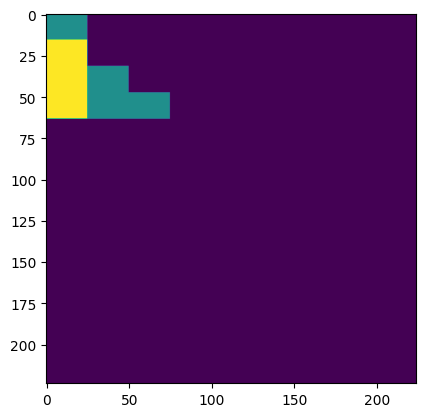

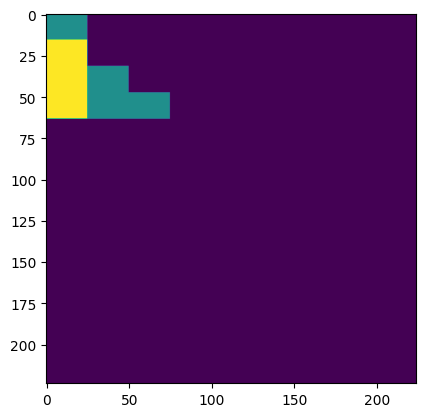

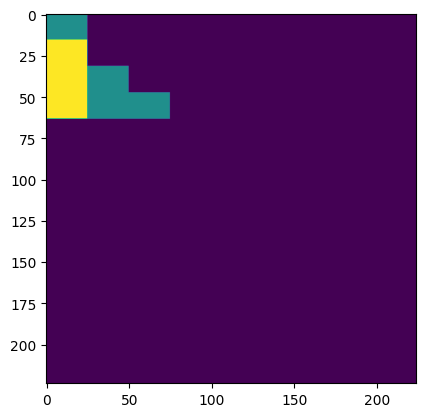

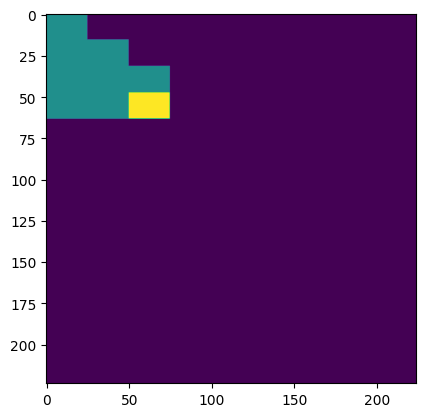

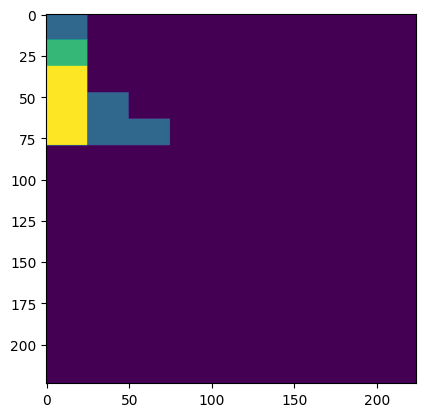

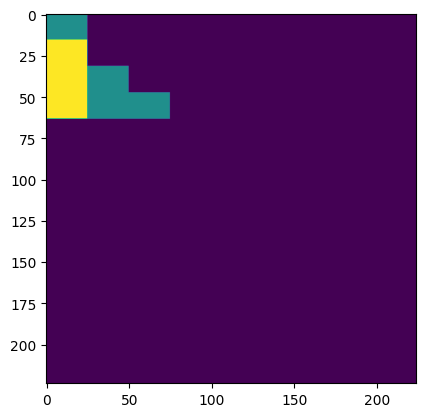

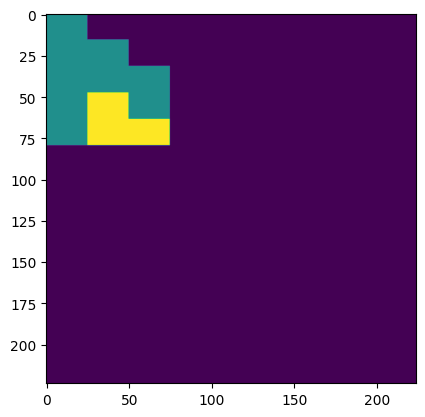

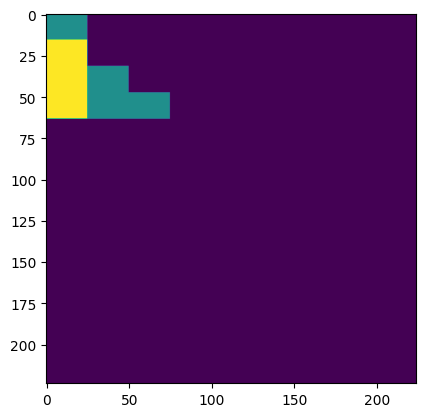

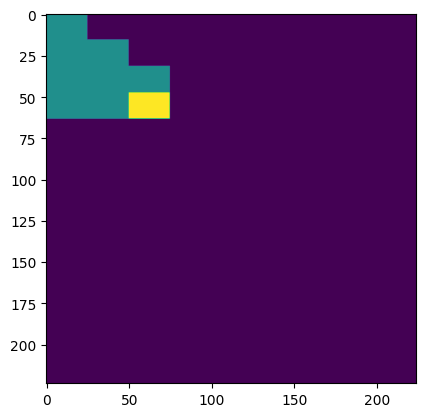

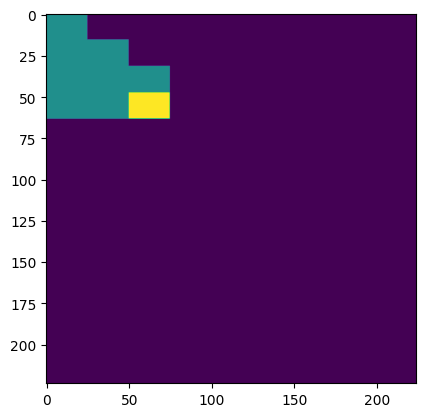

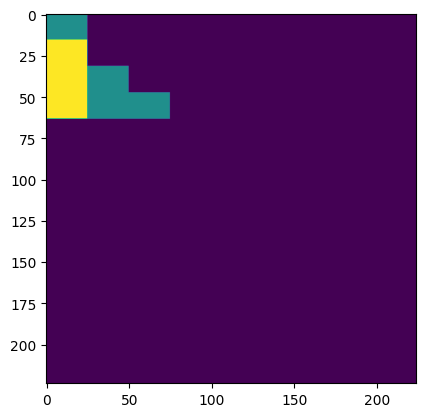



Cluster1



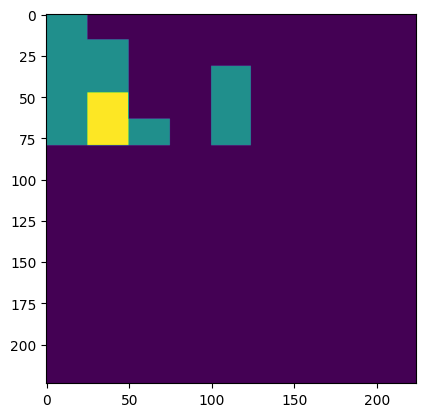

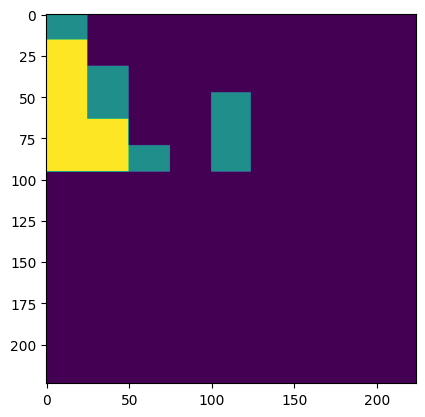

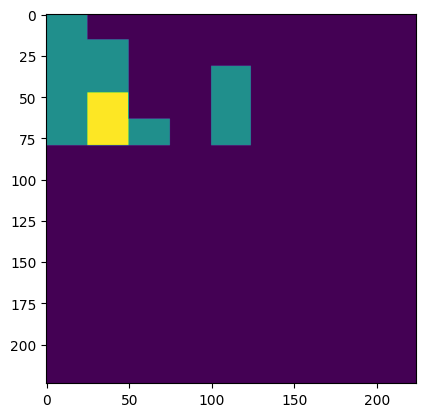

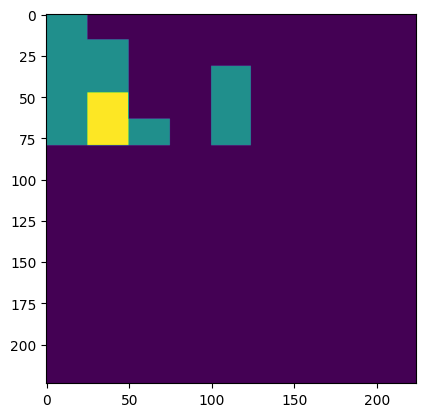

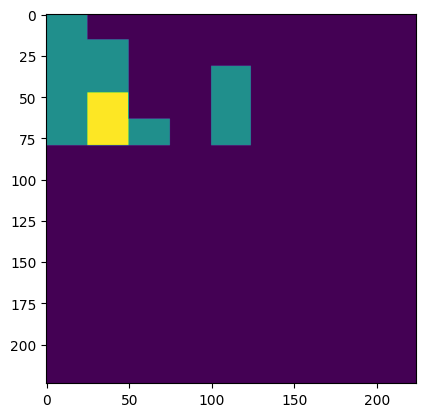

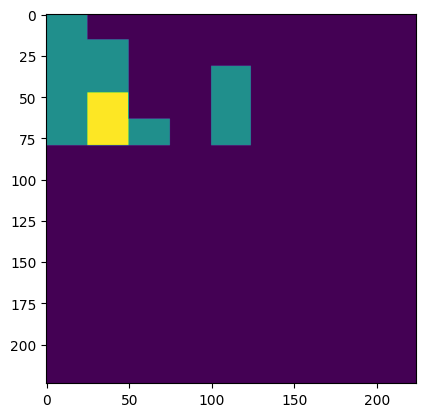

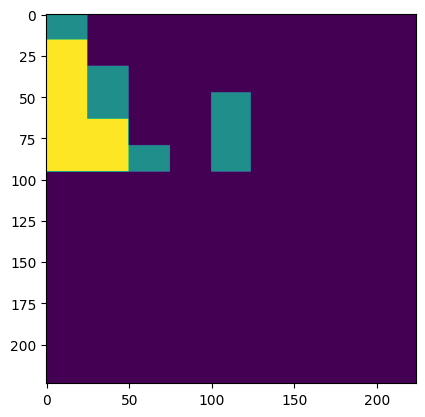

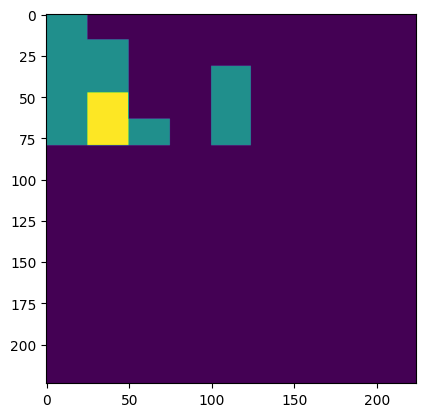

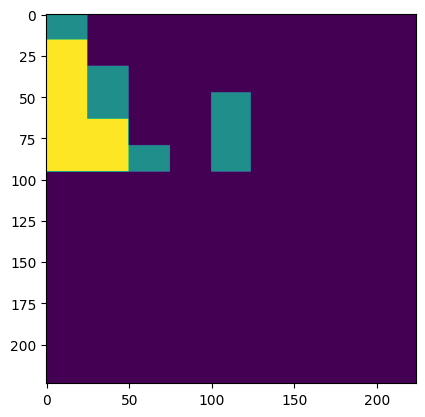

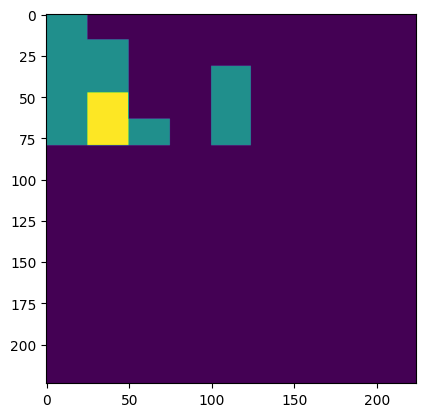

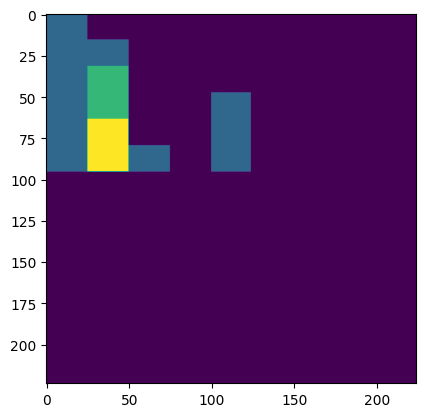

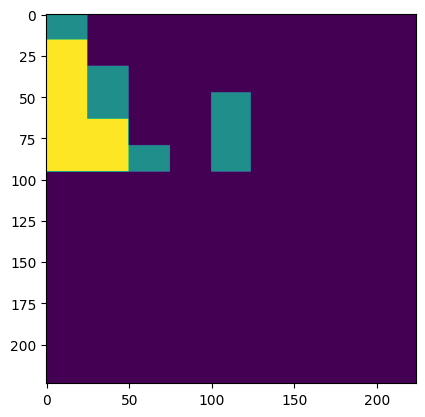



Cluster2



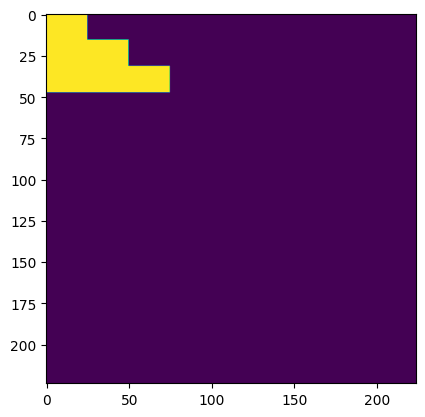

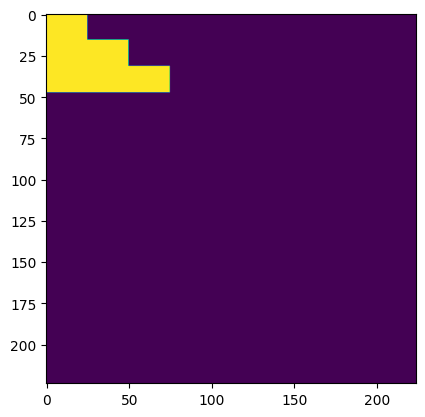

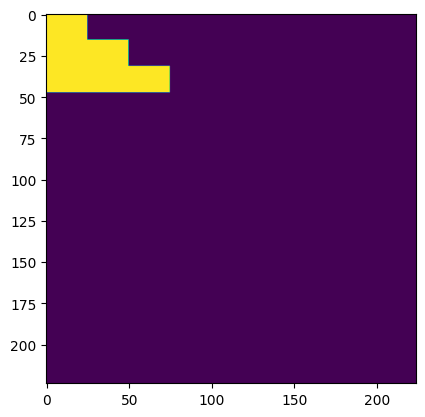

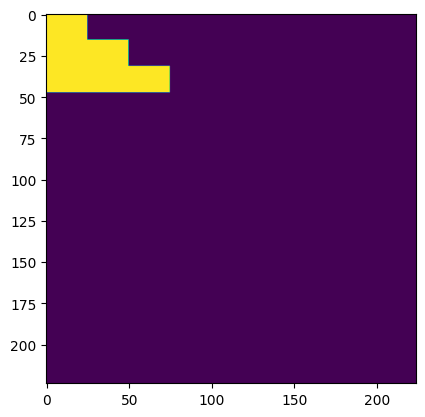

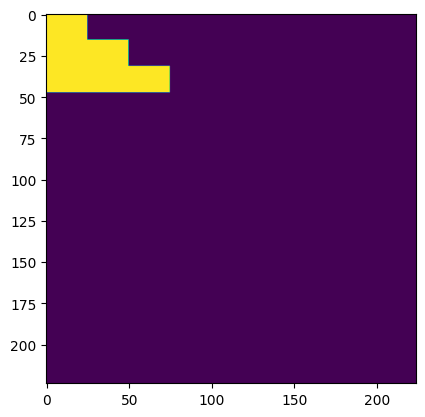

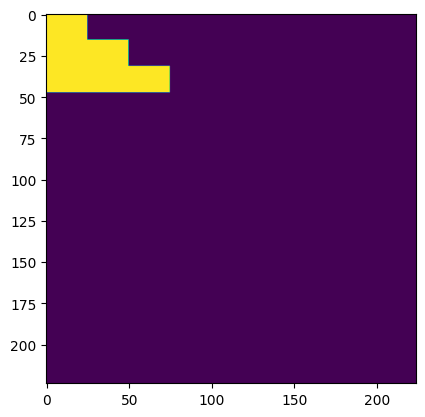

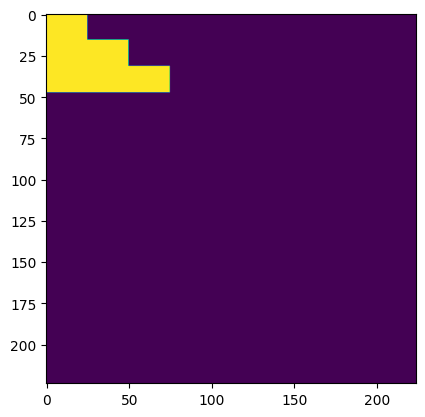

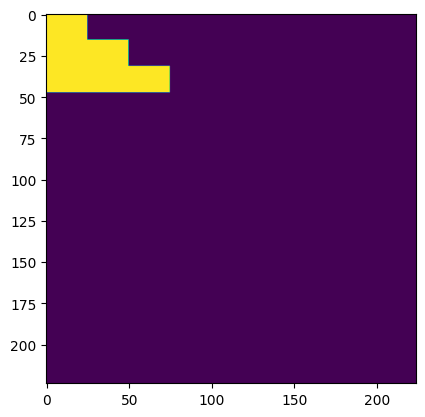

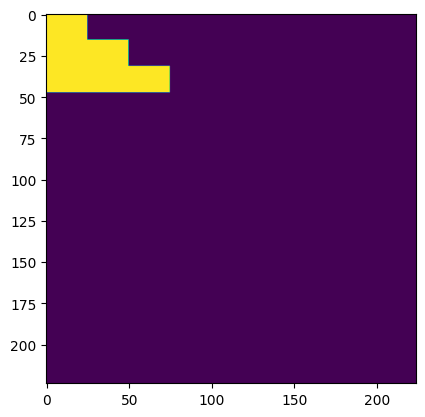

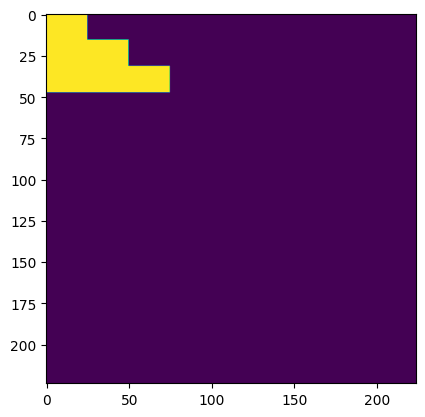

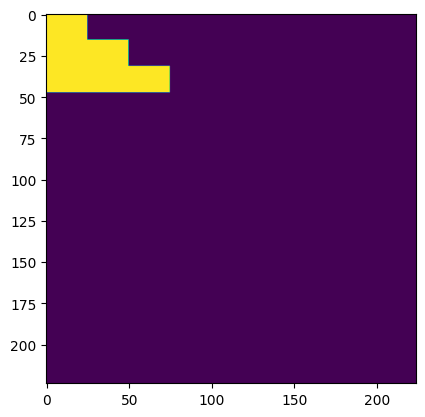

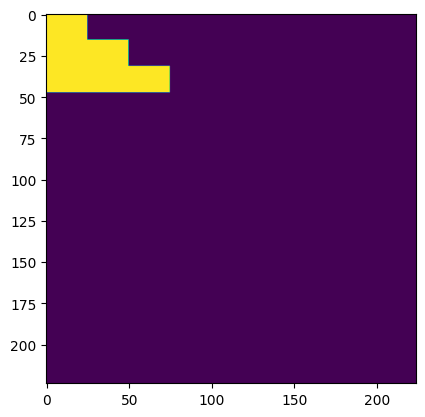

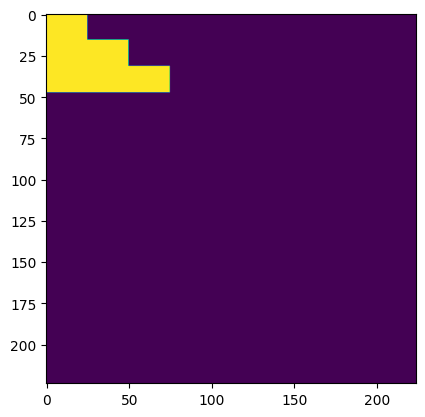

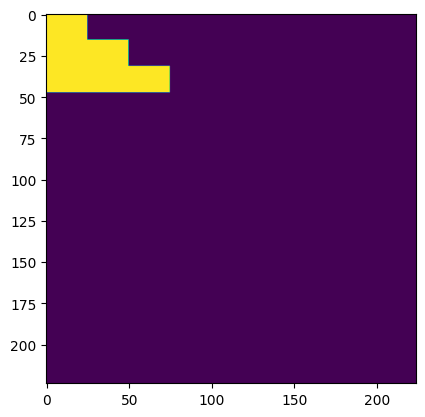

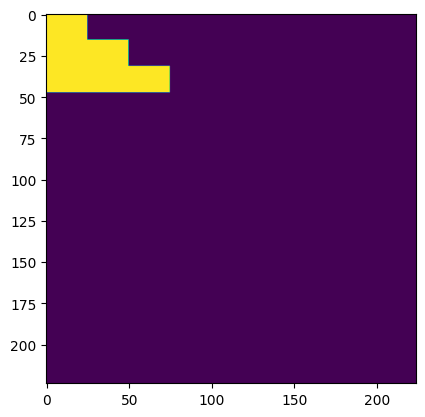

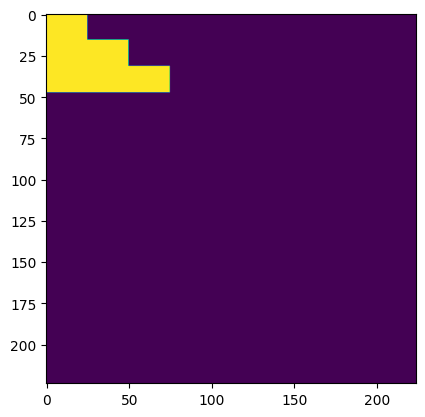

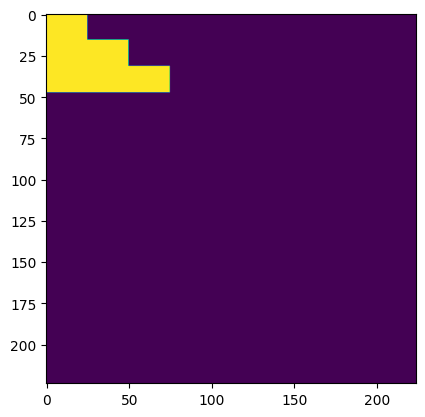

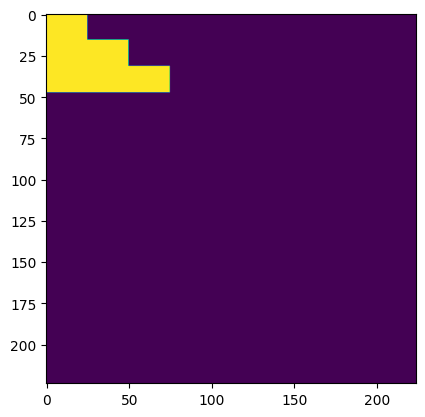

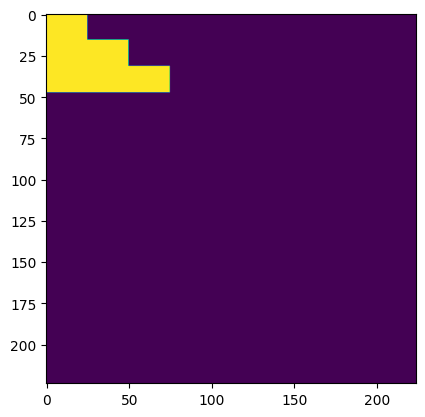

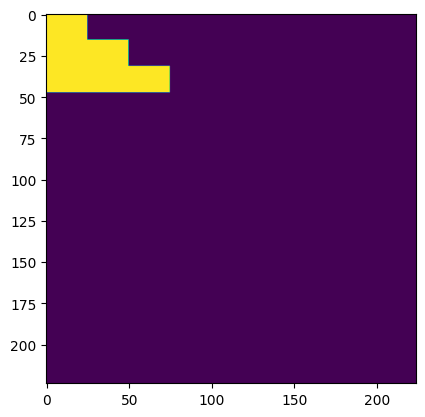

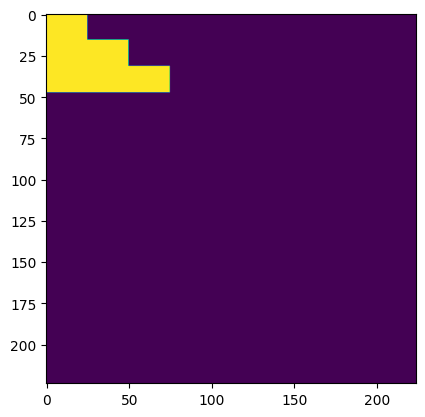

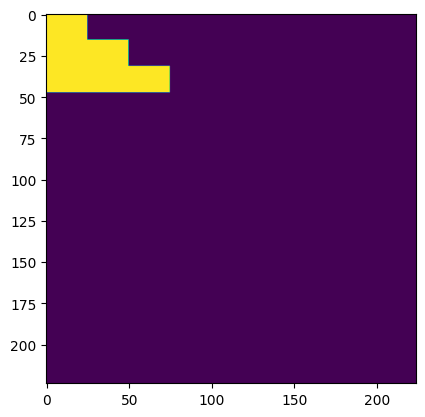

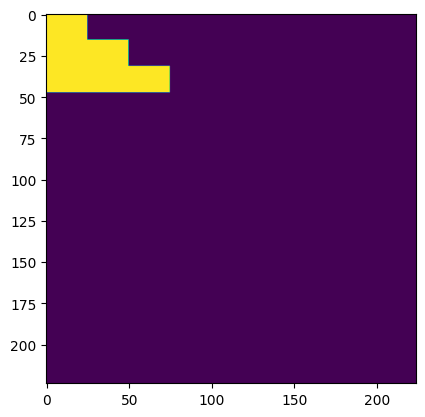

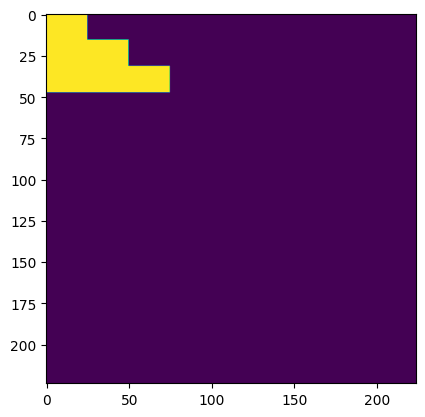

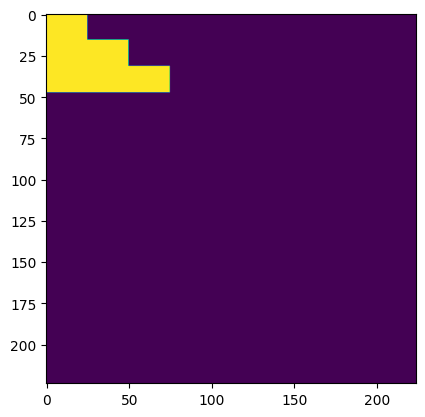

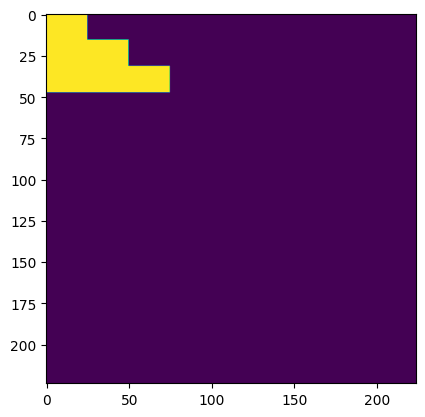

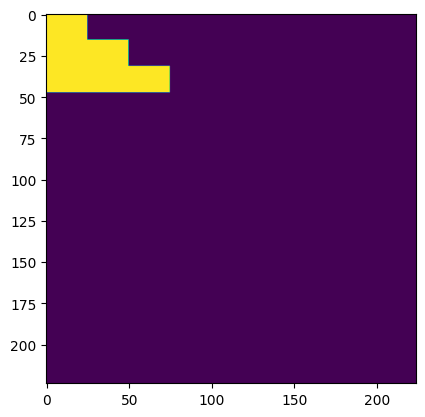

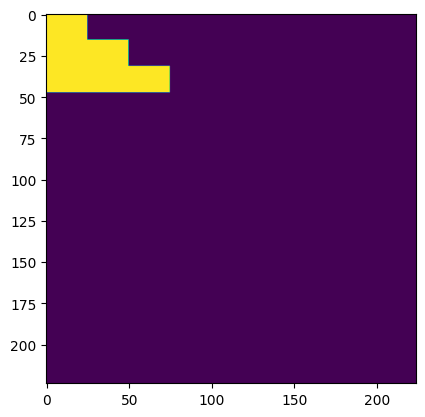

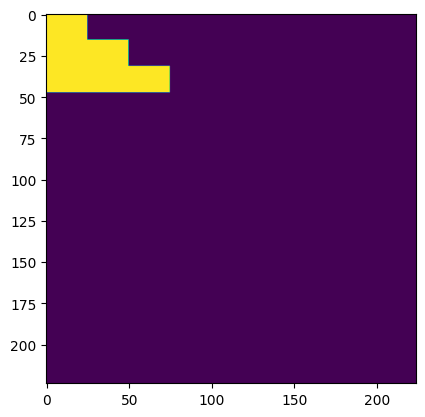

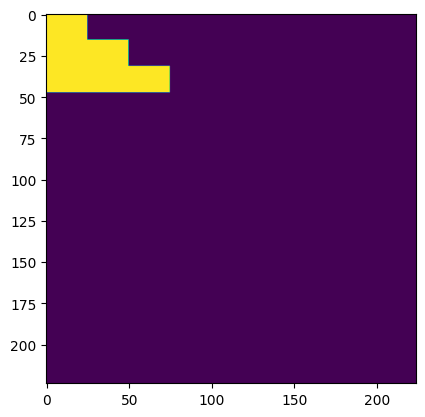

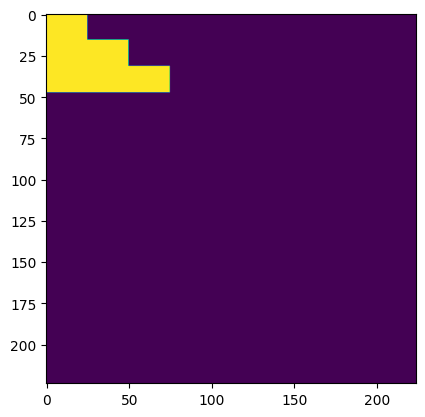

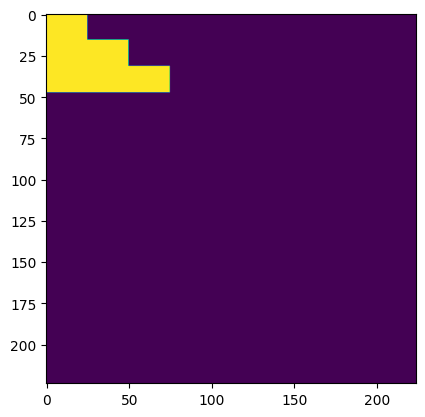

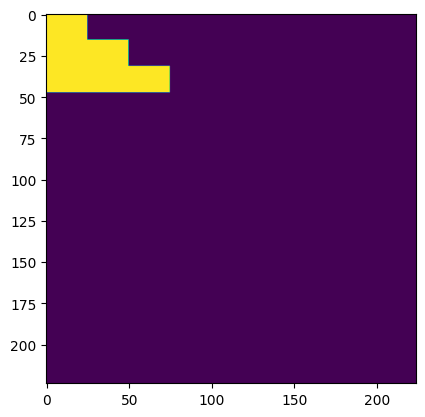

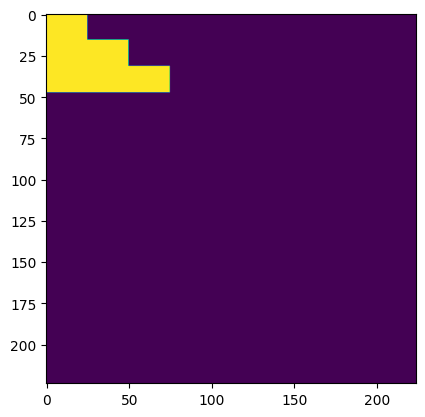

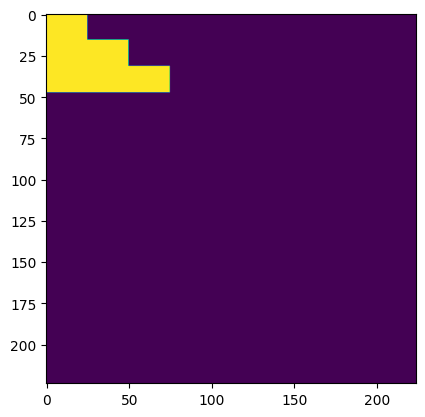

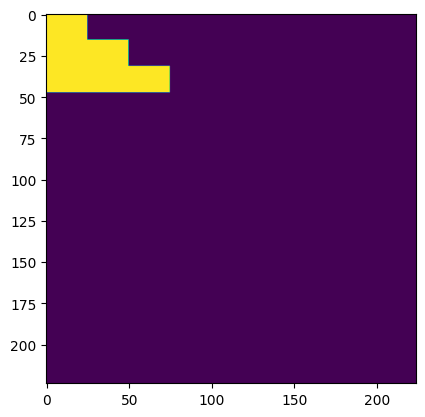

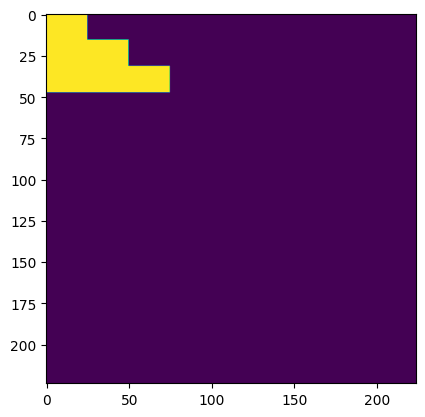

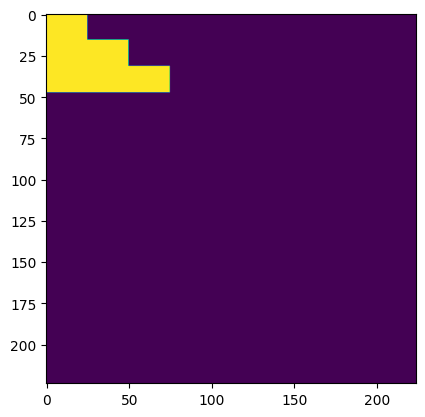

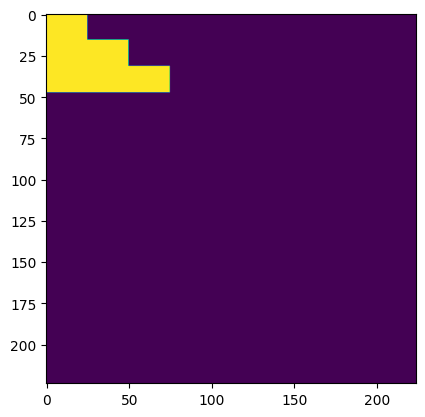

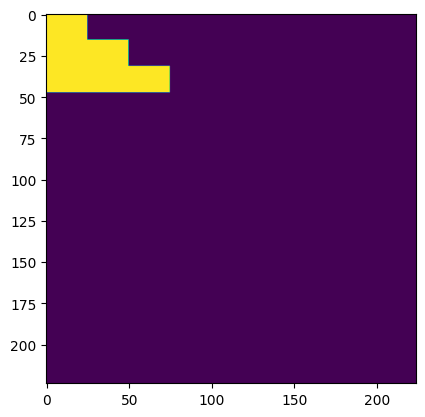

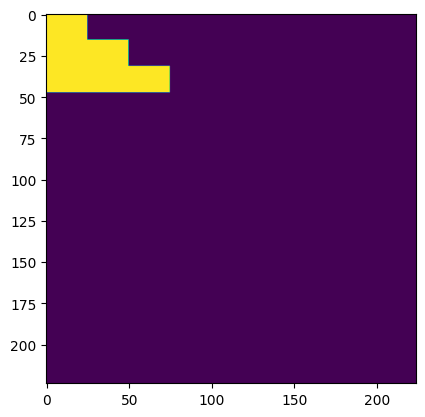

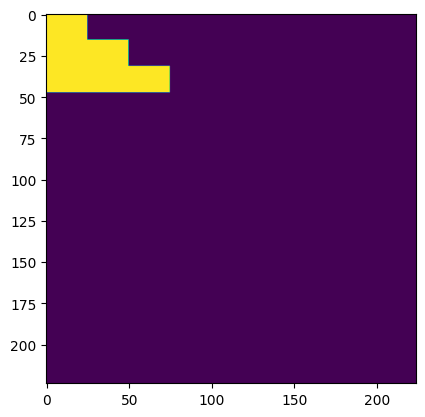

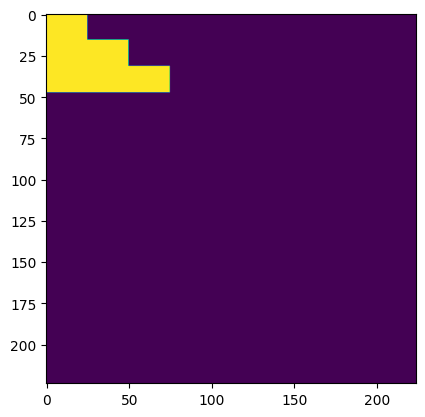

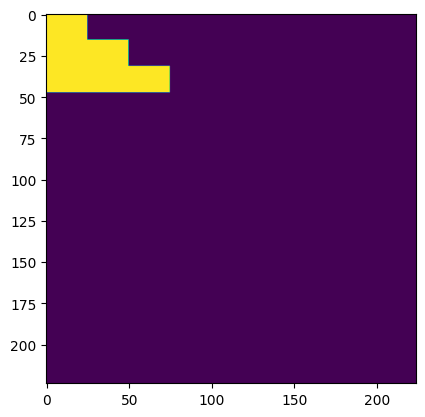

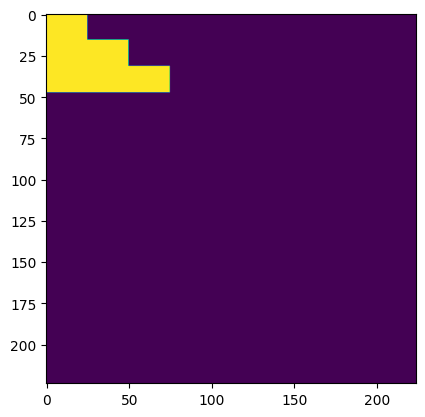

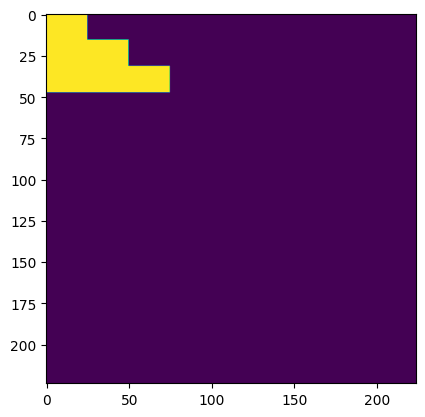

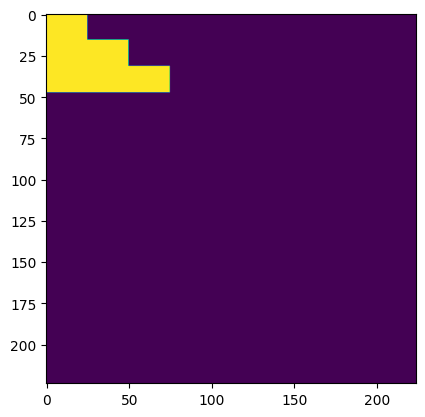

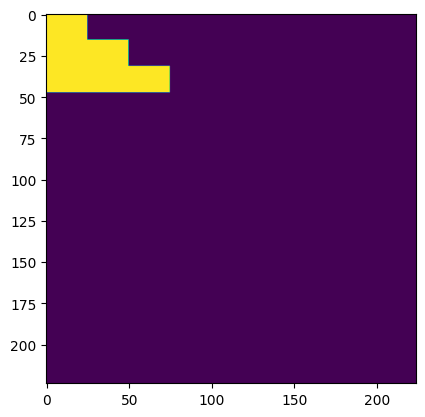

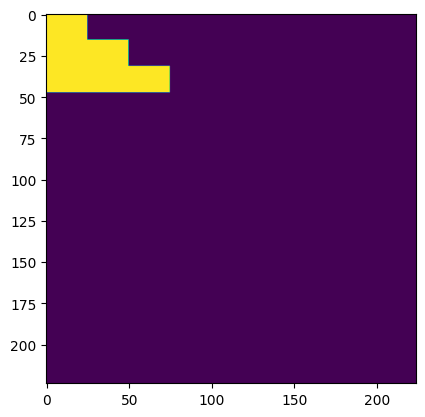

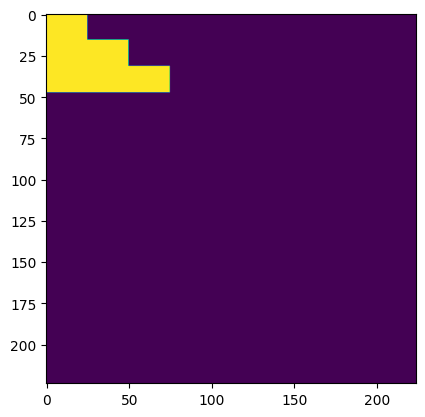

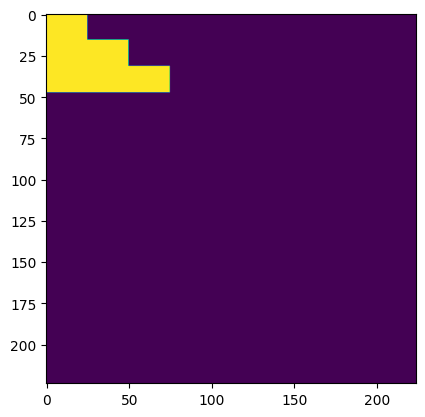

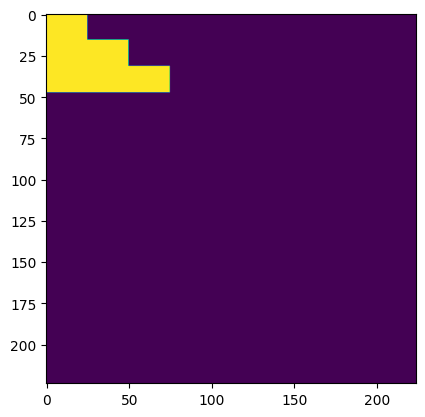



Cluster3



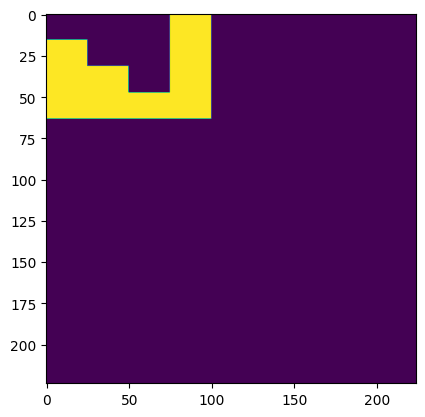

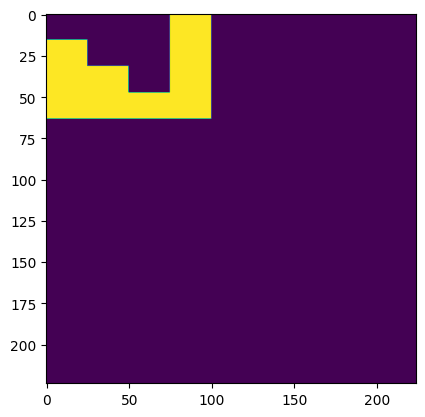

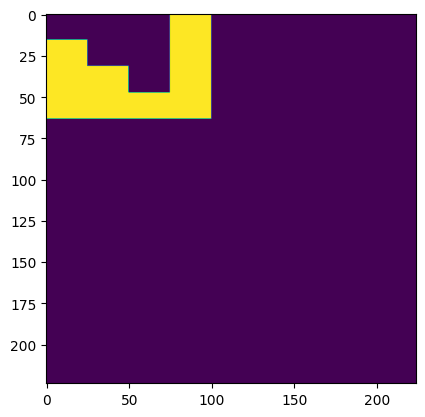



Cluster4



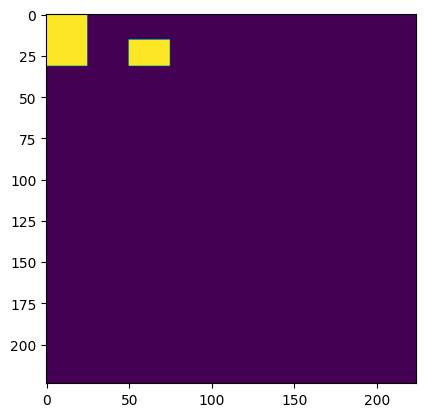

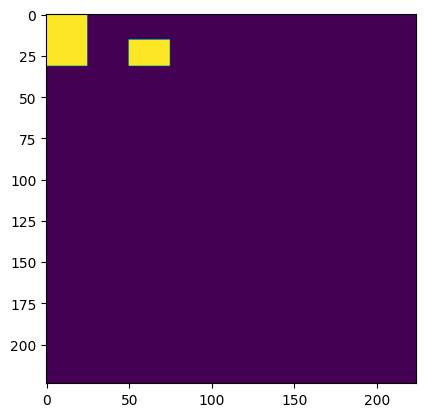

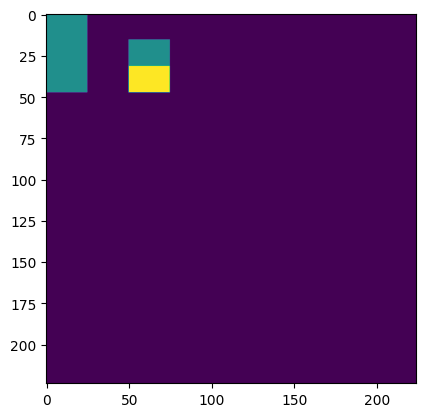

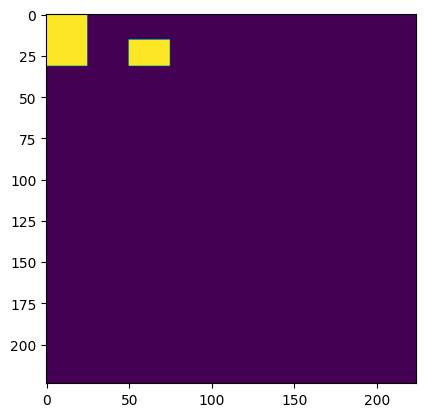

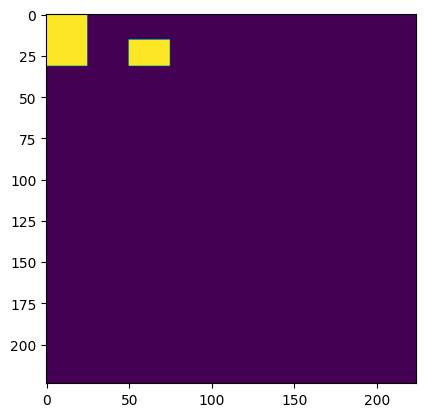

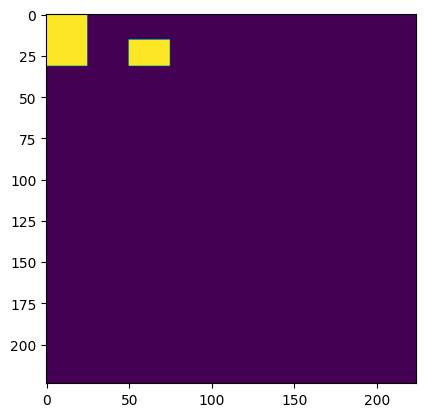

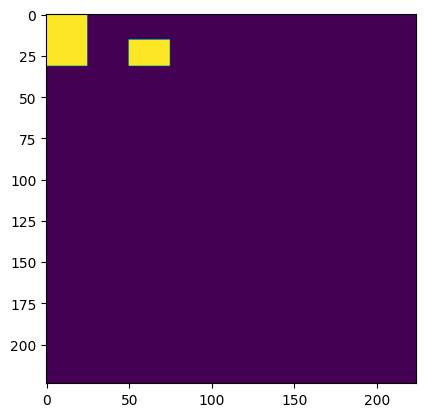

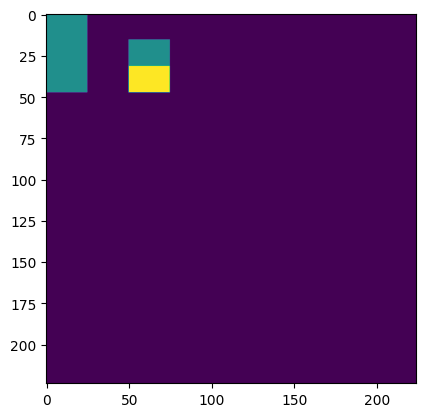

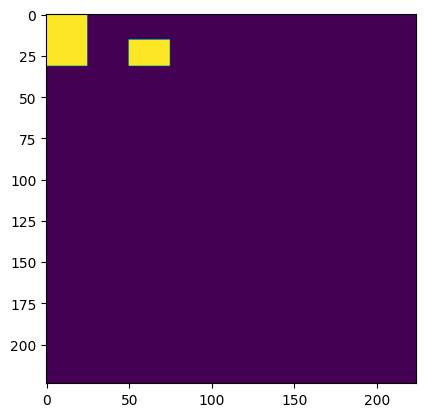



Cluster5



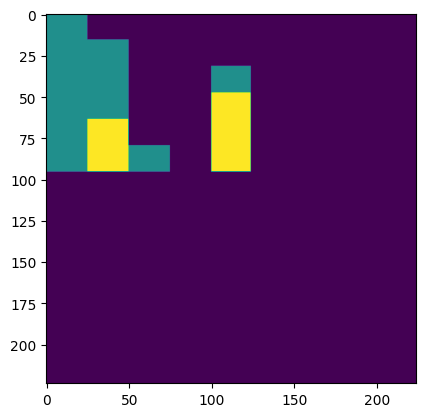

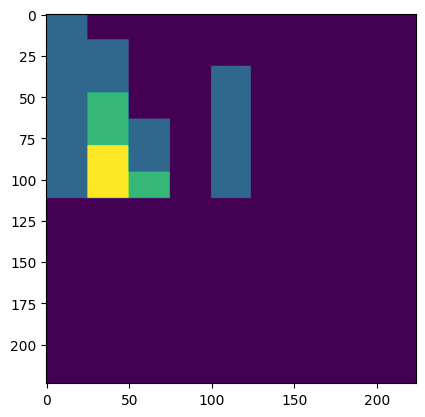

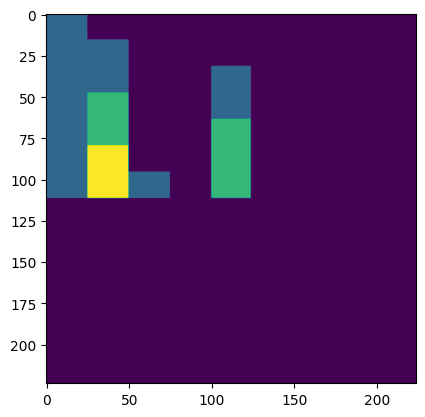

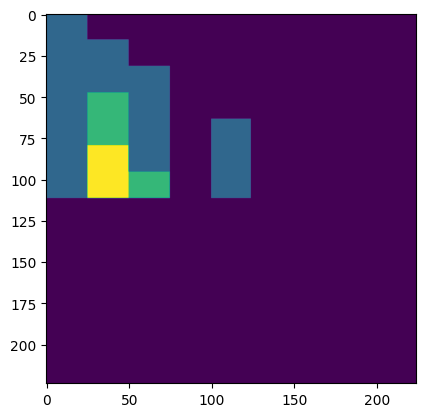



Cluster6



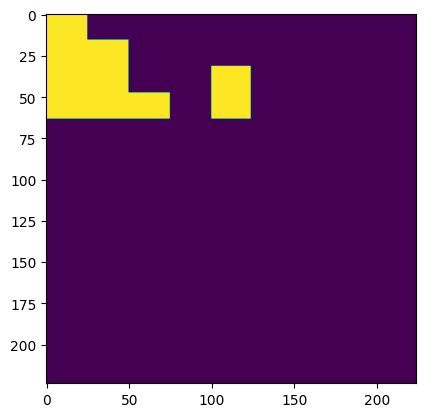

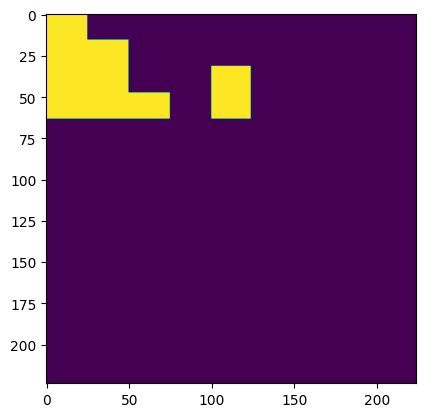

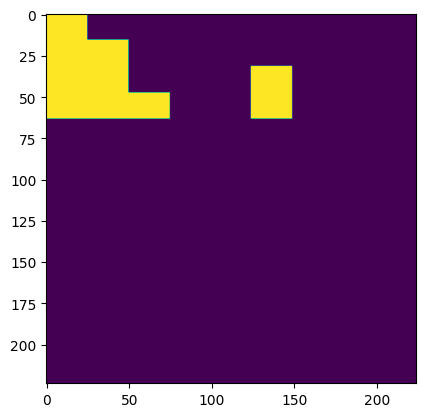

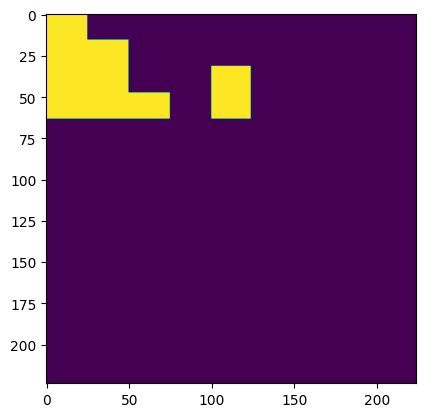

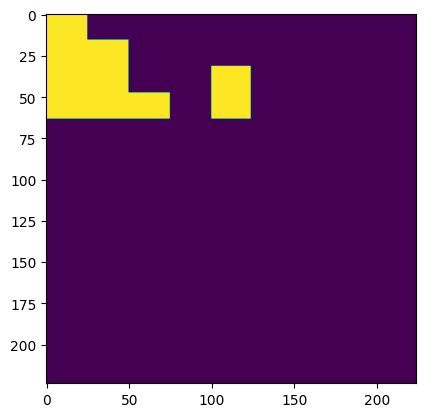

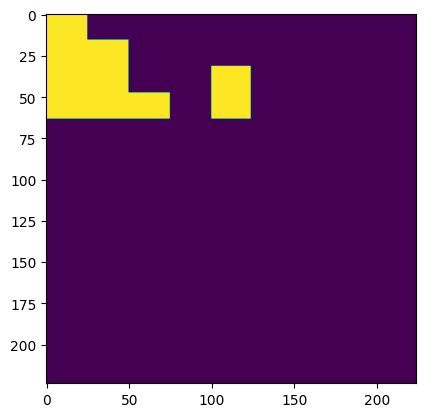

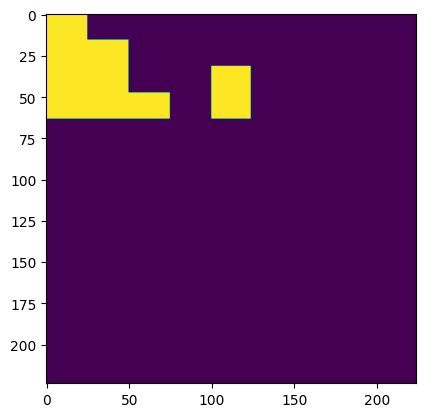

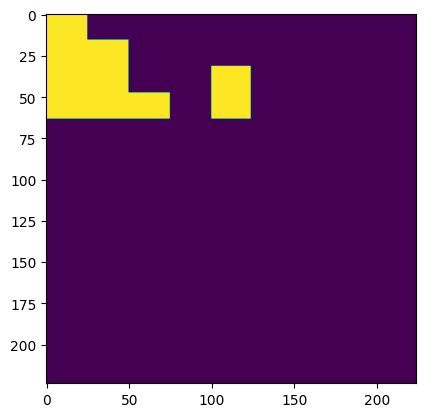

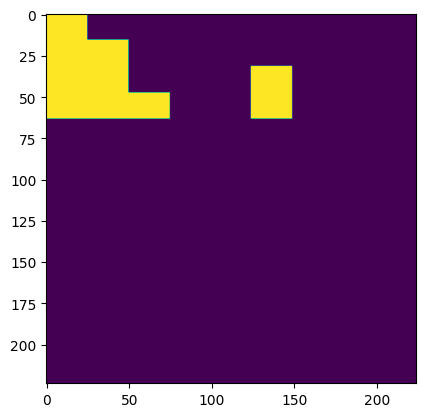

In [11]:
import matplotlib.image as mpimg
for i in range(unique_labels):
  print("Cluster" + str(i))
  print()
  for img in groups[i]:
    plt.imshow(mpimg.imread(img))
    plt.show()
  print()
  print()